In [2]:
from sklearn.model_selection import GridSearchCV
import gensim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
import embeddingvectorizer
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.multiclass import OneVsRestClassifier 
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier 

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier

from sklearn.model_selection import cross_val_score
from collections import defaultdict
from tabulate import tabulate
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from nltk.corpus import stopwords
from string import punctuation
import nltk
import pandas as pd
from collections import Counter
from nltk.stem.snowball import SnowballStemmer


In [11]:
OUTPUT_PATH ='../output/'
PATH = '/Users/anne/surfdrive/uva/projects/RPA_KeepingScore/data/RPA_data_with_dictionaryscores.pkl'
PE = '/Users/anne/repos/embedding_models/RPA/w2v_300d2000-01-01_2018-12-31'

In [ ]:
print("\nLoading model")
mod = gensim.models.Word2Vec.load(PE)
MDL = dict(zip(mod.wv.index2word, mod.wv.syn0))

In [6]:
df = pd.read_pickle(PATH)

In [7]:
# only keep newspaper data
df = df[df['type'] == 'newspaper']
# define frames
frames = ['attrresp', 'cnflct','ecnmc', 'hmnintrst']

# 2 = not present, set to zero (0 = not present, 1 = present)
df[frames] = df[frames].replace({2:0})
df['attrresp'].fillna(0, inplace=True)
df.rename(columns= {'text_x': 'text'}, inplace=True)

Text(0.5, 0, 'category')

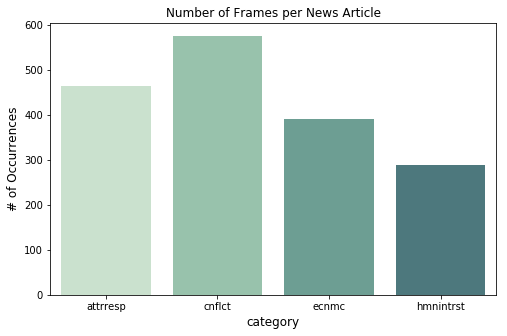

In [9]:
df_ = df[frames]
counts = []
categories = list(df_.columns.values)
for i in categories:
    counts.append((i, df_[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

plt.figure(figsize=(8,5))
ax = sns.barplot(x='category', y='number_of_comments', data=df_stats, palette=sns.cubehelix_palette(rot=-.4))
plt.title("Number of Frames per News Article")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Text(0.5, 0, '# of frames')

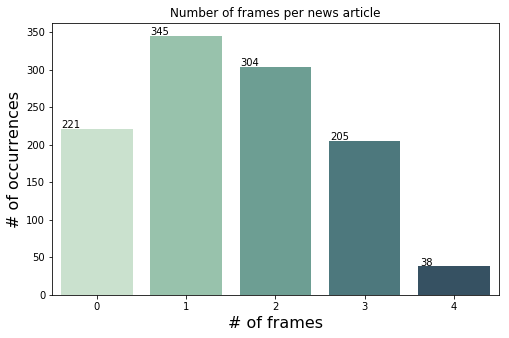

In [19]:
rowsums = df_[frames].sum(axis=1).astype(int)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values, palette=sns.cubehelix_palette(rot=-.4))
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    
plt.title("Number of frames per news article")
plt.ylabel('# of occurrences', fontsize=16)
plt.xlabel('# of frames', fontsize=16)

In [ ]:
train, test = train_test_split(df, random_state=42, test_size=0.3, shuffle=True)

x_train = train.text
x_test = test.text

In [ ]:
list(train.columns)

In [ ]:
## clean att
mystopwords = stopwords.words('dutch')
extra_stop = [line.strip() for line in open('../stopwords/stopwords_NL.txt').readlines() if len(line)>1]
mystopwords = set(mystopwords + extra_stop)

def get_dictionaries(frame):
    att = " ".join(train[frame].dropna().to_list())
    body_of_text="".join([l for l in att.lower() if l not in punctuation])  
    body_of_text=" ".join(body_of_text.split())
    text_clean = " ".join([w for w in body_of_text.split() if w not in mystopwords and len(w) > 1]) 
    attribution_clean = " ".join([w for w in text_clean.split() if w.isalpha()]) 
    att = set(attribution_clean.split())
    return attribution_clean, att

In [ ]:
print("Some info on the dictionaries:\n\n")
print("The dictionary Attribution of Responsibility contains {} words. These are the most common words:\n\n{}\n\n".format(len(get_dictionaries('attrresp_wrds')[1]), Counter(get_dictionaries('attrresp_wrds')[0].split()).most_common(5)))
print("The dictionary Human Interst contains {} words. These are the most common words:\n\n{}\n\n".format(len(get_dictionaries('hmnintrst_wrds')[1]), Counter(get_dictionaries('hmnintrst_wrds')[0].split()).most_common(5)))
print("The dictionary Economic Consequences contains {} words. These are the most common words:\n\n{}\n\n".format(len(get_dictionaries('ecnmc_wrds')[1]), Counter(get_dictionaries('ecnmc_wrds')[0].split()).most_common(5)))
print("The dictionary Conflict contains {} words. These are the most common words:\n\n{}\n\n".format(len(get_dictionaries('cnflct_wrds')[1]), Counter(get_dictionaries('cnflct_wrds')[0].split()).most_common(5)))

In [ ]:
def get_final_dicts():
    frame_dict = defaultdict()
    frame_dict['att_d'] = [i[0] for i in Counter(get_dictionaries('attrresp_wrds')[0].split()).most_common(50)]
    frame_dict['hmninstr_d'] = [i[0] for i in Counter(get_dictionaries('hmnintrst_wrds')[0].split()).most_common(50)]
    frame_dict['cnflct_d'] = [i[0] for i in Counter(get_dictionaries('cnflct_wrds')[0].split()).most_common(50)]
    frame_dict['ecnm_d'] = [i[0] for i in Counter(get_dictionaries('ecnmc_wrds')[0].split()).most_common(50)]
    return frame_dict

In [ ]:
def get_stemmed_dict():
    stemmer = SnowballStemmer("dutch")
    d = get_final_dicts()
    stemmed_dictionary = {}
    for frame, words in d.items():
        stemmed_dictionary[frame] = [ stemmer.stem(w) for w in words ]
    return stemmed_dictionary

get_stemmed_dict()

In [ ]:
def map_dict_to_text(type_of_text, stemmed):
    result = []
    for document, documentnr in zip(test[type_of_text], test['documentnr']):
        topics_per_document = {}
        document = str(document)
        if stemmed == False:
            d = get_final_dicts()
        elif stemmed == True:
            d = get_stemmed_dict()
        for topic, words in d.items():
            try:
                match = [x for x in words if x in document.lower().split(' ')]
            except:
                print("HU", document)
                match = []

            topics_per_document = {'documentnr' : documentnr,
                                    'frame': topic,
                                    'len matches' : len(match),
                                    'words matches' : match }
            result.append(topics_per_document)
    df2 = pd.DataFrame.from_dict(result)
    df3 = df2.pivot(index='documentnr', columns='frame', values='len matches')
    df3[df3>1] = 1
    return df3

In [ ]:
#test['stemmed_text']

In [ ]:
#df3 = df2.pivot(index='documentnr', columns='frame', values='len matches')
#df3[df3>1] = 1

#df1 = get_tp_fp_fn(type_of_text = 'text', stemmed = False)
#df2 = map_dict_to_text(type_of_text = 'stemmed_text', stemmed = True)

In [ ]:
#df1[['cnflct_d', 'cnflct', '_tp cnflct', '_fn cnflct', '_fp cnflct']]

#df1.columns

In [ ]:
def get_tp_fp_fn(type_of_text, stemmed):

    '''create columns with true postives, false positives, and false negatives'''
  #  df = pd.merge(test, df3, how= 'left', on = 'documentnr')
    df3 = map_dict_to_text(type_of_text = type_of_text, stemmed = stemmed)
    df = pd.merge(test, df3, how= 'left', on = 'documentnr')
    frames = ['attrresp', 'cnflct','ecnmc', 'hmnintrst']
    frames_d = ['att_d' , 'cnflct_d', 'ecnm_d','hmninstr_d']

    
    for frame, frame_d in zip(frames, frames_d):
        columnname_tp = "_tp " + str(frame)
        columnname_fp = "_fp " + str(frame)
        columnname_fn = "_fn " + str(frame)
        
        df[columnname_tp] = np.where( (df[frame] == 1) & (df[frame_d] == 1) , 1, 0 )
            # false positive = dictionary identified, but golden standard not.
        df[columnname_fp] = np.where( (df[frame] != 1) & (df[frame_d] == 1) , 1, 0 )
        # false negative = dictionary NOT identified, but golden standard DID identify
        df[columnname_fn] = np.where( (df[frame] == 2) & (df[frame_d] != 1) , 1, 0 )
        
    return df


In [ ]:
def get_recall_precision(frames, type_of_text, stemmed):

    true_positives = ["_tp " + str(i) for i in frames]
    false_positives = ["_fp " + str(i) for i in frames]
    false_negatives = ["_fn " + str(i) for i in frames]

    recall = {}
    precision = {}
    f1score = {}

    df = get_tp_fp_fn(type_of_text = type_of_text, stemmed=stemmed)
    
    for tp, fp, fn, frame in zip(true_positives, false_positives, false_negatives, frames) :

        recall[str(frame)] = df[tp].sum(axis=0) / ( df[tp].sum(axis=0) + df[fn].sum(axis=0) )
        precision[str(frame)] = df[tp].sum(axis=0) / ( df[tp].sum(axis=0) + df[fp].sum(axis=0) )
        f1score[str(frame)] = 2 * ( ( precision[str(frame)] * recall[str(frame)] ) / ( precision[str(frame)] + recall[str(frame)] ) )
        
    recall['total'] = sum(recall.values()) / len(recall.values())
    precision['total'] = sum(precision.values()) / len(precision.values())
    f1score['total'] = sum(f1score.values()) / len(f1score.values())
    
    return recall, precision, f1score

In [ ]:
frames = ['attrresp', 'cnflct','ecnmc', 'hmnintrst']
recall, precision, f1score = get_recall_precision(frames = frames, type_of_text = 'stemmed_text', stemmed=True)
f1score

In [ ]:
recall, precision, f1score = get_recall_precision(frames = frames, type_of_text = 'text', stemmed=False)
total = { k: [ precision[k] , recall[k], f1score[k]] for k in recall }

In [ ]:
total

In [ ]:
for document in test['stemmed_text']:
        documentnr += 1
        topics_per_document = {}
        d = get_stemmed_dict()
        for topic, words in d.items():
            match = [x for x in words if x in document.lower().split(' ')]
            doc_string = document.lower().split(' ')
            index = [doc_string.index(word) for word in match ]
            try:
                index_smallest = min(index)
            except:
                index_smallest = np.nan

            topics_per_document = {'documentnr' : documentnr,
                                    'stemmed_topic_label_dictionary': topic,
                                    'stemmed_index_words' : index,
                                    'stemmed_smallest_index' : index_smallest,
                                    'stemmed_len matches' : len(match),
                                    'stemmed_words matches' : match  ,
                                    'stemmed_text' : document.lower()}
            result.append(topics_per_document)
        return result

In [ ]:
hmnintrst = [item for sublist in hmnintrst for item in sublist]
cnflct = [item for sublist in cnflct for item in sublist]
ecnm = [item for sublist in ecnm for item in sublist]

In [70]:
p = '/Users/anne/repos/RPA/output/frames/SML_results'

with open(p) as handle:
            dictdump = json.loads(handle.read()) 
            
df = pd.DataFrame.from_dict(dictdump)
df.sort_values(['frame', 'class_name'], ascending=False).to_csv(OUTPUT_PATH + 'results_frames.csv')
df.class_name.unique()

array(['SVC count', 'PA tfidf embedding', 'SVC tfidf embedding',
       'ET count', 'SVC count embedding', 'ET count embedding',
       'ET tifdf embedding', 'PA tfidf', 'ET tfidf', 'PA count',
       'SVC tfidf', 'PA count embedding'], dtype=object)

In [40]:
['SVC count', 'PA tfidf embedding', 'SVC tfidf embedding',
       'ET count', 'SVC count embedding', 'ET count embedding',
       'ET tifdf embedding', 'PA tfidf', 'ET tfidf', 'PA count',
       'SVC tfidf', 'PA count embedding']

['Albaugh et al. - not stemmed ~ Dictionary Approach',
     'Albaugh et al. (Dictionary) - stemmed ~ Dictionary Approach',
     'Support Vector Machines (SVM) ~ tfidf',
     'Support Vector Machines (SVM) ~ w2v tfidf',
     'Support Vector Machines (SVM) ~ count',
     'Support Vector Machines (SVM) ~ w2v count',
     'Passive Agressive ~ count',
     'Passive Agressive ~ w2v count',
     'Passive Agressive ~ tfidf',
     'Passive Agressive ~ w2v tfidf',
     'Stochastic Gradient Descent (SGD) ~ count',
     'Stochastic Gradient Descent (SGD) ~ w2v count',
     'Stochastic Gradient Descent (SGD) ~ tfidf',
     'Stochastic Gradient Descent (SGD) ~ w2v tfidf',
     'ExtraTrees ~ count',
     'ExtraTrees ~ w2v count',
     'ExtraTrees ~ tfidf',
     'ExtraTrees ~ w2v tfidf']
    

['Albaugh et al. - not stemmed ~ Dictionary Approach',
 'Albaugh et al. (Dictionary) - stemmed ~ Dictionary Approach',
 'Support Vector Machines (SVM) ~ tfidf',
 'Support Vector Machines (SVM) ~ w2v tfidf',
 'Support Vector Machines (SVM) ~ count',
 'Support Vector Machines (SVM) ~ w2v count',
 'Passive Agressive ~ count',
 'Passive Agressive ~ w2v count',
 'Passive Agressive ~ tfidf',
 'Passive Agressive ~ w2v tfidf',
 'Stochastic Gradient Descent (SGD) ~ count',
 'Stochastic Gradient Descent (SGD) ~ w2v count',
 'Stochastic Gradient Descent (SGD) ~ tfidf',
 'Stochastic Gradient Descent (SGD) ~ w2v tfidf',
 'ExtraTrees ~ count',
 'ExtraTrees ~ w2v count',
 'ExtraTrees ~ tfidf',
 'ExtraTrees ~ w2v tfidf']

Text(0.5, 0, '')

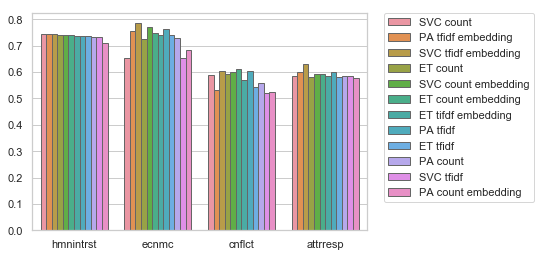

In [73]:
ax = sns.barplot(x="frame", y="accuracy",hue='class_name', edgecolor=".4",  data=df)
ax = sns.set_style("white")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title(None)
plt.ylabel(None)
plt.xlabel(None)

In [146]:
import json
import logging
import pandas as pd

logger = logging.getLogger()
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')
logging.root.setLevel(level=logging.INFO)

class plot_accuracy_precision_recall():
    '''...'''

    def __init__(self, path_to_data, path_to_output):
        self.path_to_data = path_to_data
        self.path_to_output = path_to_output
        self.translator = {'hmnintrst' : 'Human interest', 'ecnmc' : 'Economic consequences', 'cnflct' : 'Conflict', 
                           'attrresp' : 'Attribution of responsibility'}
  #      with open('../resources/numbers_to_topic.json') as handle:
   #            self.translator_numeric = json.loads(handle.read()) 
        
    def get_data_dictionary(self):
         # getting Dictionary Approach Data
        fname = '{}recision_recall_f1score_dictionary_stemmed_FRAMES.json'.format(self.path_to_data)
        logger.info(fname)
        
        with open(fname) as handle:
            dictdump =  json.loads(handle.read()) 
            
        df = pd.DataFrame.from_dict(dictdump).transpose()
        df['classifier'] = 'Dictionary - stemmed'

        fname_notstemmed = '{}recision_recall_f1score_dictionary_not_stemmed_FRAMES.json'.format(self.path_to_data)
        logger.info(fname_notstemmed)

        with open(fname_notstemmed) as handle:
            dictdump =  json.loads(handle.read()) 
            
        df2 = pd.DataFrame.from_dict(dictdump).transpose()
        df2['classifier'] = 'Dictionary - not stemmed'
        
        df = pd.concat([df, df2])
        df.rename(columns={0 :'precision',  1 :'recall', 2 :'f1-score', 3 : 'accuracy'}, inplace=True)
        df.rename(index=self.translator, inplace=True)
        df['approach'] = 'Dictionary Approach'
        return df
    
    def get_data_sml(self):
    
        fname_sml = '{}SML_results_text_cleaned'.format(self.path_to_data)
        with open(fname_sml) as handle:
            dictdump =  json.loads(handle.read()) 
        df = pd.DataFrame.from_dict(dictdump)
        df['frame'].replace(self.translator, inplace=True)
        df.set_index('frame', inplace=True)
      #  df[]'frame', inplace=True)
        df = df[['class_name','f1_macro', 'precision_macro', 'recall_macro', 'accuracy']]
        df.rename(columns={'class_name': 'classifier', 'f1_macro' : 'f1-score', 'precision_macro' : 'precision', 'recall_macro' : 'recall'}, inplace=True)
        df['approach'] = 'SML'
        return df
    
    def combine_datasets(self):
        df1 = self.get_data_dictionary()
        df2 = self.get_data_sml()
        df = pd.concat([df1, df2])
     #   df.drop('total', inplace=True)
        df['Frame'] = df.index
        return df

In [147]:
PATH = '../output/frames/'
OUTPUT_PATH ='../output/'

a = plot_accuracy_precision_recall(PATH, OUTPUT_PATH)
df = a.combine_datasets()

df

2019-10-28 16:04:06,983 : INFO : ../output/frames/recision_recall_f1score_dictionary_stemmed_FRAMES.json
2019-10-28 16:04:06,993 : INFO : ../output/frames/recision_recall_f1score_dictionary_not_stemmed_FRAMES.json
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,accuracy,approach,classifier,f1-score,precision,recall,Frame
Attribution of responsibility,0.458084,Dictionary Approach,Dictionary - stemmed,0.403542,0.540986,0.517712,Attribution of responsibility
Conflict,0.526946,Dictionary Approach,Dictionary - stemmed,0.454113,0.536914,0.518495,Conflict
Economic consequences,0.685629,Dictionary Approach,Dictionary - stemmed,0.684993,0.716829,0.726260,Economic consequences
Human interest,0.371257,Dictionary Approach,Dictionary - stemmed,0.368518,0.579137,0.562025,Human interest
Attribution of responsibility,0.467066,Dictionary Approach,Dictionary - not stemmed,0.391060,0.633301,0.535038,Attribution of responsibility
Conflict,0.556886,Dictionary Approach,Dictionary - not stemmed,0.502976,0.582538,0.549313,Conflict
Economic consequences,0.724551,Dictionary Approach,Dictionary - not stemmed,0.723121,0.745373,0.760401,Economic consequences
Human interest,0.413174,Dictionary Approach,Dictionary - not stemmed,0.412647,0.546343,0.550161,Human interest
Human interest,0.741977,SML,SVC count embedding,0.465764,0.836641,0.520668,Human interest
Human interest,0.738156,SML,ET tifdf embedding,0.549008,0.656115,0.559218,Human interest


In [148]:
d = { 'Dictionary - stemmed':'Dictionary - stemmed',
     'Dictionary - not stemmed':  'Dictionary - not stemmed',
     'SVC count embedding': 'Support Vector Machines (SVM) ~ w2v count',
      'SVC tfidf embedding':  'Support Vector Machines (SVM) ~ w2v tfidf',
     'ET count':  'ExtraTrees ~ count',
    'ET tfidf':  'ExtraTrees ~ tfidf',
    'ET count embedding' : 'ExtraTrees ~ w2v count',
    'SVC tfidf': 'Support Vector Machines (SVM) ~ tfidf',
    'SVC count': 'Support Vector Machines (SVM) ~ count',
        'ET tifdf embedding':  'ExtraTrees ~ w2v tfidf',
        'PA tfidf': 'Passive Agressive ~ tfidf',
        'PA count': 'Passive Agressive ~ count',
        'PA count embedding': 'Passive Agressive ~ w2v count',
        'PA tfidf embedding':  'Passive Agressive ~ w2v tfidf',
     'SGD count': 'Stochastic Gradient Descent (SGD) ~ count',
     'SGD count embedding' : 'Stochastic Gradient Descent (SGD) ~ w2v count',
     'SGD tfidf' : 'Stochastic Gradient Descent (SGD) ~ tfidf',
     'SGD tfidf embedding' : 'Stochastic Gradient Descent (SGD) ~ w2v tfidf' }

order = ['Dictionary - not stemmed',
         'Dictionary - stemmed' ,
     'Support Vector Machines (SVM) ~ tfidf',
     'Support Vector Machines (SVM) ~ w2v tfidf',
     'Support Vector Machines (SVM) ~ count',
     'Support Vector Machines (SVM) ~ w2v count',
     'Passive Agressive ~ count',
     'Passive Agressive ~ w2v count',
     'Passive Agressive ~ tfidf',
     'Passive Agressive ~ w2v tfidf',
     'Stochastic Gradient Descent (SGD) ~ count',
     'Stochastic Gradient Descent (SGD) ~ w2v count',
     'Stochastic Gradient Descent (SGD) ~ tfidf',
     'Stochastic Gradient Descent (SGD) ~ w2v tfidf',
     'ExtraTrees ~ count',
     'ExtraTrees ~ w2v count',
     'ExtraTrees ~ tfidf',
     'ExtraTrees ~ w2v tfidf']

df['classifier_updated'] = df['classifier'].map(d)
df

,accuracy,approach,classifier,f1-score,precision,recall,Frame,classifier_updated
Attribution of responsibility,0.458084,Dictionary Approach,Dictionary - stemmed,0.403542,0.540986,0.517712,Attribution of responsibility,Dictionary - stemmed
Conflict,0.526946,Dictionary Approach,Dictionary - stemmed,0.454113,0.536914,0.518495,Conflict,Dictionary - stemmed
Economic consequences,0.685629,Dictionary Approach,Dictionary - stemmed,0.684993,0.716829,0.726260,Economic consequences,Dictionary - stemmed
Human interest,0.371257,Dictionary Approach,Dictionary - stemmed,0.368518,0.579137,0.562025,Human interest,Dictionary - stemmed
Attribution of responsibility,0.467066,Dictionary Approach,Dictionary - not stemmed,0.391060,0.633301,0.535038,Attribution of responsibility,Dictionary - not stemmed
Conflict,0.556886,Dictionary Approach,Dictionary - not stemmed,0.502976,0.582538,0.549313,Conflict,Dictionary - not stemmed
Economic consequences,0.724551,Dictionary Approach,Dictionary - not stemmed,0.723121,0.745373,0.760401,Economic consequences,Dictionary - not stemmed
Human interest,0.413174,Dictionary Approach,Dictionary - not stemmed,0.412647,0.546343,0.550161,Human interest,Dictionary - not stemmed
Human interest,0.741977,SML,SVC count embedding,0.465764,0.836641,0.520668,Human interest,Support Vector Machines (SVM) ~ w2v count
Human interest,0.738156,SML,ET tifdf embedding,0.549008,0.656115,0.559218,Human interest,ExtraTrees ~ w2v tfidf


2019-10-28 16:05:49,573 : WARNING : No handles with labels found to put in legend.


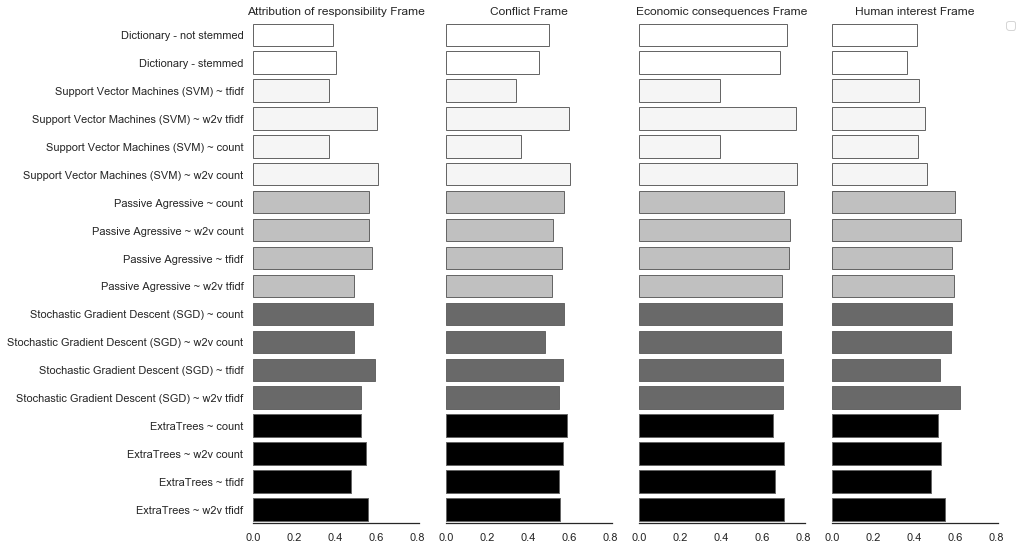

In [150]:
colour = ['white', 'white', 'whitesmoke', 'whitesmoke', 'whitesmoke', 'whitesmoke', 'silver', 'silver', 'silver', 'silver', 'dimgray', 'dimgray', 'dimgray', 'dimgray', 'black', 'black', 'black', 'black']

ax = sns.catplot(y="classifier_updated", x="f1-score", edgecolor=".4", palette=colour, col="Frame", order = order,
                data=df, kind="bar", saturation=.5,
                height=8, aspect=.45)


ax.set_titles("{col_name} {col_var}").despine(left=True)

ax.set(xlabel=None, ylabel=None)

ax = sns.set_style("white")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#colour = ['whitesmoke' if x=='w2v tfidf' else 'dimgray' if x== 'w2v count' else 'black' if x== 'count' else 'silver' if x== 'tfidf' else 'white' for x in approach ]
plt.show()

In [151]:
#df.sort_values('Frame')

# Create the dictionary that defines the order for sorting
sorterIndex = dict(zip(order,range(len(order))))
# Generate a rank column that will be used to sort
# the dataframe numerically
df['Tm_Rank'] = df['classifier_updated'].map(sorterIndex)
df.sort_values(['Frame','Tm_Rank']).to_csv('../output/results_frames.csv')

In [48]:
df.classifier.unique()

array(['Dictionary - stemmed', 'Dictionary - not stemmed',
       'SVC count embedding', 'SVC tfidf embedding', 'ET count',
       'ET tfidf', 'ET count embedding', 'SVC tfidf', 'SVC count',
       'ET tifdf embedding', 'PA tfidf', 'PA count', 'PA count embedding',
       'PA tfidf embedding'], dtype=object)

In [ ]:
f, ax = plt.subplots(figsize=(10,14))
sns.set_context('talk')
sns.set(style="whitegrid")

ax = sns.barplot(x="accuracy", y="Frame", hue = "classifier", edgecolor=".7",  palette="ch:.25", data=df)
ax = sns.set_style("white")
plt.title(None)
plt.ylabel(None)
plt.xlabel(None)

In [ ]:
df[['accuracy', 'recall']].sum(axis=1).sum(axis=0)


In [ ]:
r = []
final_dict = {}
for k, v in results.items():
    print(k)
    for class_name, scoring in v:
        final_dict = {'frame': k,
                      'class_name': class_name,
                      'accuracy': scoring['test_acc'].mean(), 
                      'precision_micro': scoring['test_prec_micro'].mean(), 
                      'f1_micro': scoring['test_f1_micro'].mean() , 
                      'recall_macro': scoring['test_rec_macro'].mean() , 
                      'precision_macro': scoring['test_prec_macro'].mean(), 
                      'f1_macro': scoring['test_f1_macro'].mean() , 
                      'recall_micro': scoring['test_rec_micro'].mean() }
        r.append(final_dict)

df = pd.DataFrame.from_dict(r)
df.sort_values(['frame', 'f1_micro'], ascending=False, inplace=True)

fname = '{}SML_results'.format()
df.to_json(fname)

In [ ]:
fname = '{}SML_results'.format(OUTPUTPATH)
df.to_json(fname)

In [ ]:

SVC_tfidf_pipeline = Pipeline([
                ('tfidf',  TfidfVectorizer()),
                ('clf', OneVsRestClassifier(SVC())),
            ])

SVC_count_pipeline = Pipeline([
                ('count',  CountVectorizer()),
                ('clf', OneVsRestClassifier(SVC())),
            ])

all_models = [ ("SVC tfidf", SVC_tfidf_pipeline ) , ("SVC count",  SVC_count_pipeline  ) ]
              
          

scoring = {'f1_micro' : 'f1_micro', 
           'acc': 'accuracy',
           'prec_macro': 'precision_micro',
           'rec_macro': 'recall_micro'}


results = defaultdict(list)
for f in frames:
    print(f)
    unsorted_scores = [(name, cross_validate(model, x_train, train[f], cv=2, scoring=scoring)) for name, model in all_models]
    results[f] += unsorted_scores
    
    
    
results = defaultdict(list)
for f in frames:
    print(f)
    unsorted_scores = [(name, cross_val_score(model, x_train, train[f], cv=5, scoring='f1_micro').mean()) for name, model in all_models]
    results[f] += unsorted_scores


for k, v in results.items():
    scores = sorted(v, key=lambda x: -x[1])
    print('\n\n')
    print(tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

In [ ]:
r = []
final_dict = {}

for k, v in results.items():
    print(k)
    for class_name, scoring in v:
        print(class_name)
        acc = scoring['test_acc'].mean()
        prec = scoring['test_prec_micro'].mean()
        f1score = scoring['test_f1_micro'].mean()
        final_dict = {'frame': k,
                      'class_name': class_name,
                      'test_acc': acc, 
                      'test_prec_micro': prec, 
                      'test_f1_micro': f1score  }
        r.append(final_dict)

pd.DataFrame.from_dict(r)

In [ ]:
results = defaultdict(list)
for f in frames:
    print(f)
    unsorted_scores = [(name, cross_val_score(model, x_train, train[f], cv=2, scoring='f1_micro').mean()) for name, model in all_models]
    results[f] += unsorted_scores

In [ ]:
for k, v in results.items():
    scores = sorted(v, key=lambda x: -x[1])
    print('\n\n')
    print(tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

In [ ]:
for model in models:
    print(model)
    for category in frames:
        print('**Processing {} comments...**'.format(category))

        # Training logistic regression model on train data
        model.fit(x_train, train[category])

        # calculating test accuracy
        prediction = model.predict(x_test)
        print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
        print("\n")

In [ ]:
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                 ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(PassiveAggressiveClassifier())),
            ])

for category in frames:
    print('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print(classification_report(test[category], prediction))
    print("\n")
    